In [2]:
import tone
import utils
from utils import *

tone.utils.ipython.autoreload(utils)
tone.utils.learning.ignore_warning()
device = tone.utils.learning.try_use_device()
device

device(type='cuda')

1 (64, 64, 1)


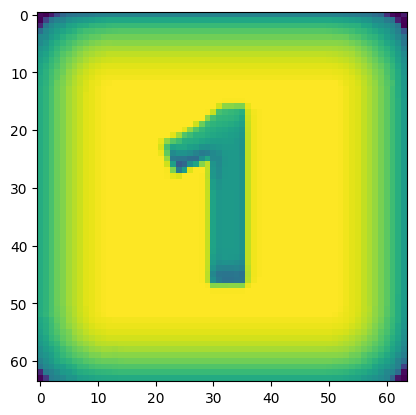

In [8]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self) -> None:
        super().__init__()
        self.images = []
        files = glob.glob("images/*")
        for file in files:
            match = re.match(r".+\\(\d+)\.png", file)
            idx = int(match.group(1))
            image = Image.open(file).convert("L")
            image = image.resize((64, 64))
            image = np.asarray(image)
            image = torch.from_numpy(image).float().to(device) / 255.0
            image = image.unsqueeze(0)
            # image = image.permute(2, 0, 1)
            self.images.append((image, idx))

        self.images = sorted(self.images, key=lambda e: e[1])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        return self.images[index]


dataset = Dataset()
idx = 1

image, label = dataset[idx]
image = image.cpu().permute(1, 2, 0).numpy()
plt.imshow(image)
print(label, image.shape)

In [4]:
from classifier import Classifer

dataloader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_size=13,
    shuffle=True,
    generator=torch.Generator(device=device),
)

model = Classifer()
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=0.1,
)
criterion = nn.BCELoss()
epoch = 2000

bar = tqdm(range(epoch))
for _ in bar:
    for x, t in dataloader:
        t = F.one_hot(t, 13).float()
        y = model.forward(x)

        loss = criterion(y, t)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        bar.set_postfix(loss=loss.item())


  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:29<00:00, 68.61it/s, loss=0.000784]


In [5]:
for x, t in dataloader:
    y = model.forward(x)
    idx = torch.argmax(y, dim=1)
    print(sum(idx != t))

tensor(0)


In [6]:
tone.utils.learning.save_pickle(model, "./model.pkl")

In [7]:
model.eval()
model.predict(dataset[1][0].unsqueeze(0))

tensor(1)